In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from utilities import generate_connection_matrix, sample_uniform_noise, generate_dataset, sample_from_disjoint_interval

In [ ]:
import random
import networkx as nx

def perturb_adjacency_matrix(matrix, n=1, mode='both'):
    """
    Perturbs a weighted adjacency matrix by adding/removing edges,
    preserving causal order (i.e., j < i for edge j → i).

    Parameters:
    - matrix: np.ndarray, square weighted adjacency matrix
    - n: number of edges to add/remove
    - mode: 'add', 'remove', or 'both'
    - weight_range: tuple, range of weights to assign when adding edges

    Returns:
    - new_matrix: np.ndarray, perturbed matrix
    """

    new_matrix = matrix.copy()
    num_nodes = new_matrix.shape[0]
    
    # Collect removable and addable edges
    removable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] != 0]
    addable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] == 0]
    
    if mode in ['remove', 'both']:
        to_remove = random.sample(removable_edges, min(n, len(removable_edges)))
        for i, j in to_remove:
            new_matrix[i, j] = 0.0

    if mode in ['add', 'both']:
        to_add = random.sample(addable_edges, min(n, len(addable_edges)))
        for i, j in to_add:
            weight = sample_from_disjoint_interval(1)[0]
            new_matrix[i, j] = weight

    return new_matrix



def get_causal_order(matrix):
    G = nx.DiGraph()
    num_nodes = matrix.shape[0]

    # Add edges from matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i, j] != 0:
                G.add_edge(j, i)  # edge from parent j to child i

    # Compute topological sort
    try:
        causal_order = list(nx.topological_sort(G))
        return causal_order
    except nx.NetworkXUnfeasible:
        raise ValueError("The graph contains cycles and is not a DAG.")

In [3]:
%load_ext autoreload
%autoreload 2

In [52]:
P = [5, 6, 7] # number of variables/features
S = [0.5, 0.45, 0.55]#[0.2, 0.25, 0.3] # edge probabilities (control the sparsity)
C = 2 #number of groups
PERT = 0.15 #perturbation level

In [ ]:
def simulate_multigroup_data(P, S, C, PERT, shared_permutation=True, seed=None):
    rng = np.random.default_rng(seed)
    p = rng.choice(P)
    s = rng.choice(S)
    B = generate_connection_matrix(p, s)
    make_dot(B)
    perm = None
    datasets = []
    matrices = []
    sample_sizes = [rng.integers(int(10_000), int(15_000)) for _ in range(C)] #change 10_000 and 15_000 with 1.2*p and 2.5*p
    
    for c in range(C):
        n_perturb = int(np.count_nonzero(B) * PERT)
        Bc = perturb_adjacency_matrix(B, n_perturb, "both")
        make_dot(Bc)
        variances = rng.uniform(1, 3, size=p)
        E = sample_uniform_noise(sample_sizes[c], p, variances)
        X, _, perm = generate_dataset(E, Bc, sample_sizes[c], permutation=perm 
        if shared_permutation else None)
        datasets.append(X)
        matrices.append(Bc)
    
    return datasets, matrices, perm

In [75]:
from sklearn.metrics import mean_squared_error
def average_squared_error(true_B, est_B):
    # Flatten matrices and compute MSE
    return mean_squared_error(true_B.flatten(), est_B.flatten())


In [63]:
X, Bs_true, perms = simulate_multigroup_data(P,S,C, PERT)

In [72]:
Bs_true[0] == Bs_true[1]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True, False,  True, False,  True,  True]])

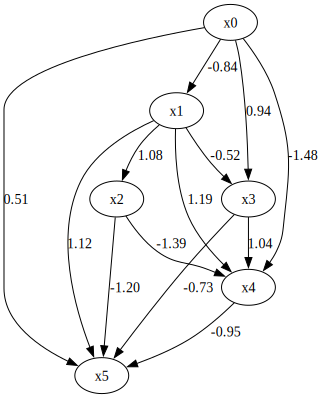

In [64]:
make_dot(Bs_true[0])

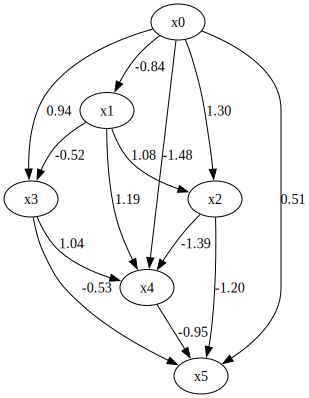

In [65]:
make_dot(Bs_true[1])

In [66]:
model = lingam.MultiGroupDirectLiNGAM()
model.fit(X)


In [67]:
inverse_perm = np.argsort(perms)
B_group1_original_order = model.adjacency_matrices_[0][inverse_perm, :][:, inverse_perm]
B_group2_original_order = model.adjacency_matrices_[1][inverse_perm, :][:, inverse_perm]


In [81]:
import cdt
from cdt.metrics import SHD

In [ ]:
SHD((Bs_true[0] != 0).astype(int), ( B_group1_original_order != 0).astype(int), True) #double_for_anticausal (bool) – Count the badly oriented edges as two mistakes. Default: True

0

In [76]:
mean_squared_error(B_group1_original_order, Bs_true[0])

0.00012938243116907656

In [77]:
mean_squared_error(B_group2_original_order, Bs_true[1])

7.581761685986649e-05

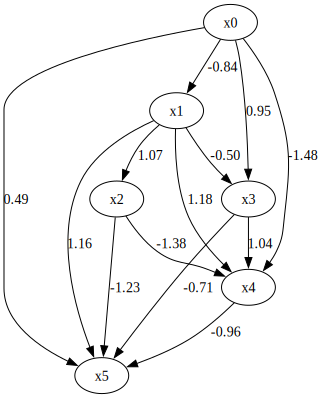

In [68]:
make_dot(B_group1_original_order)

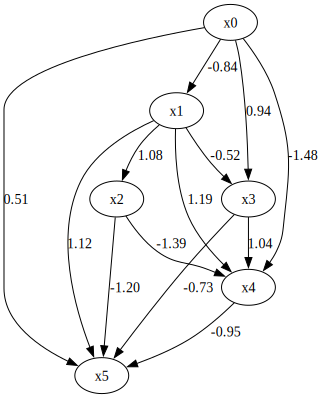

In [69]:
make_dot(Bs_true[0])

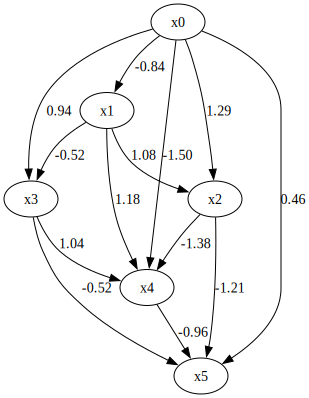

In [70]:
make_dot(B_group2_original_order)

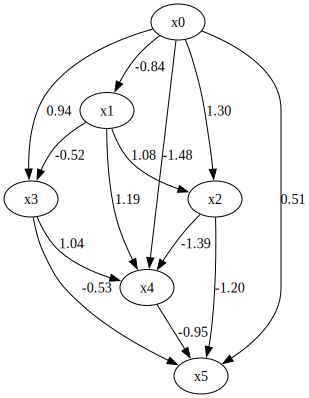

In [71]:
make_dot(Bs_true[1])